## 使用 多层感知器 对多类别数据进行分类

In [1]:
import os
import numpy as np
from sklearn import metrics
from nnc import dataset_git as Data
from nnc.plot_tool import *

In [2]:
# 定义 激活函数
def linear(x,w,t):
    # 线性运算
    return np.dot(x,w)-t
def logistic(x):
    # Logistic 激活函数
    return 1.0 /(1.0 + np.exp(-x))
def logistic_grad(x):
    f = logistic(x)
    return np.multiply(f, (1.0 - f))
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x) + np.exp(-x))
def tanh_grad(x):
    f = tanh(x)
    return 1-f**2

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

# 定义误差/损失函数
# 二分类问题 二值交叉熵损失函数
def BinaryCrossEntropyLoss(y,y_pred):
    # 二分类损失函数    
    if y.ndim <= 1:
        y = y.reshape(-1,1)
    if y_pred.ndim <= 1:
        y_pred = y_pred.reshape(-1,1)   
    num = y.shape[0]   # 样本数目
    loss = -1/num * (np.matmul(y.T,np.log(y_pred)) + np.matmul((1-y.T),np.log(1-y_pred)))
    return loss.squeeze()

def BinaryCrossEntropyLoss_grad(y,y_pred):
    # 计算损失函数对模型预测的导数
    if y.ndim <= 1:
        y = y.reshape(-1,1)
    if y_pred.ndim <= 1:
        y_pred = y_pred.reshape(-1,1)   
    num = y.shape[0]   # 样本数目
    grad = -1.0*(y/y_pred - (1-y)/(1-y_pred))/num
    return grad

# 定义误差函数 
# 二次损失函数  
def quadratic(y,y_pred):
    return np.sum((y-y_pred)**2)/2

def quadratic_grad(y,y_pred):
    return -(y-y_pred)

# 分类问题评价指标
# 准确率 Accuracy
def accuracy(labels,preds):
    return metrics.accuracy_score(labels,preds)

# 均方误差函数
def mse(y,y_pred):
    return np.mean((y-y_pred)**2)

In [3]:
# 模型预测
def predict(X,param):  
    X = X.reshape(len(X),param['input_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = tanh(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = tanh(z2)                       # 输出层的输出向量
    return np.sign(y_pred)

# 模型评价
def evaluate(dataset,param):        
    X, y = dataset
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = tanh(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = tanh(z2)                       # 输出层的输出向量 
    loss = mse(y,y_pred)
    # 准确率 Accuracy
    y_pred = np.sign(y_pred)
    score = accuracy(y,y_pred)
    return loss,score

# 样本训练 
# 2层前向神经网络结构，1-h-1
def mlp2_train(train_set,test_set,param,lr,epochs,eps,log_epochs=10):
    
    # 存放算法训练过程中的训练样本和测试样本误差
    loss = {}
    loss['train'] = []
    loss['test'] = []
    # 存放算法训练过程中的训练样本和测试样本 的分类正确率
    score = {}
    score['train'] = []
    score['test'] = []
    
    # train_set 训练数据(X,y)
    X,y = train_set
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    N = X.shape[0]  # 样本数目
    
    # 使用梯度下降法
    for epoch in range(epochs):  # 训练轮数
        y_pred = np.zeros((N,param['output_size']))    # 存放每个样本的实际输出
        for n in range(N):
            # 取出第n个样本输入网络进行权值更新
            # (1) 计算各层输出
            Xn = X[n,:].reshape(1,param['input_size'])
            z1 = linear(Xn,param['w1'],param['t1'])      # 隐层净输入向量
            y1 = tanh(z1)                                  # 隐层的输出向量
            z2 = linear(y1,param['w2'],param['t2'])        # 输出层净输入向量
            y_pred[n,:] = tanh(z2)                           # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）            
            # (2) 计算误差（损失）
            e = quadratic(y[n,:],y_pred[n,:])     # 二次损失函数 
            # 二次损失函数 关于输出y_pred的导数
            e_grad = quadratic_grad(y[n,:],y_pred[n,:]).reshape(1,param['output_size'])           
            # (3) 计算误差项(误差逐层反传)
            # 输出层激活函数（恒等变换）f(z) = z = y_pred, 输出y_pred关于净输入z2的导数等于1
            # e2 = (y[n]-y_pred[n])   
            e2 = np.multiply(- e_grad,tanh_grad(z2))
            e1 = np.multiply(tanh_grad(z1),np.matmul(e2,param['w2'].T))
            # (3) 权值和阈值修正
            param['w2'] = param['w2'] + lr* np.matmul(y1.T, e2)     # 权值修正
            param['t2'] = param['t2'] - lr* e2                      # 阈值修正
            param['w1'] = param['w1'] + lr* np.matmul(Xn.T, e1)   # 权值修正
            param['t1'] = param['t1'] - lr* e1                      # 阈值修正
        # 一轮训练结束，计算训练误差
        #train_loss = np.sum((y-y_pred)**2)
        train_loss = mse(y,y_pred)
        loss['train'].append(train_loss)
        
        train_loss = mse(y,y_pred)
        loss['train'].append(train_loss)
        y_pred = np.sign(y_pred)
        train_score = accuracy(y,y_pred)
        score['train'].append(train_score)
        
        # 对测试集进行评价        
        if test_set is not None:
            test_loss,test_score = evaluate(test_set,param)
            loss['test'].append(test_loss)
            score['test'].append(test_score)
        
        # 打印过程
        if log_epochs and epoch % log_epochs == 0:
            if test_set is None:
                np.set_printoptions(precision=4)
                print(f"[Train] epoch: {epoch}/{epochs}, train_loss: {np.around(train_loss,4)},train_score:{np.around(train_score,4)}")
            else:
                np.set_printoptions(precision=4)
                print(f"[Train/Test] epoch: {epoch}/{epochs}, train_loss/test_lost: ({np.around(train_loss,4)}/{np.around(test_loss,4)}), train_score/test_score:({np.around(train_score,4)}/{np.around(test_score,4)})")
        
        # 判断算法是否停止(评价模型)
        if train_loss < eps or epoch == epochs-1:  
            print('\n 训练结束: ')
            if train_loss < eps:
                print(f' - 算法迭代次数: {epoch+1}')
            else:
                print(f' - 算法迭代次数: {epoch}')
            return loss,score,param


    

开始训练 ......
[Train] epoch: 0/100, train_loss: 1.2985,train_score:0.3333
[Train] epoch: 5/100, train_loss: 0.5903,train_score:0.6667
[Train] epoch: 10/100, train_loss: 0.3804,train_score:0.3333
[Train] epoch: 15/100, train_loss: 0.0209,train_score:1.0
[Train] epoch: 20/100, train_loss: 0.0141,train_score:1.0
[Train] epoch: 25/100, train_loss: 0.0109,train_score:1.0
[Train] epoch: 30/100, train_loss: 0.0088,train_score:1.0
[Train] epoch: 35/100, train_loss: 0.0074,train_score:1.0
[Train] epoch: 40/100, train_loss: 0.0064,train_score:1.0
[Train] epoch: 45/100, train_loss: 0.0056,train_score:1.0
[Train] epoch: 50/100, train_loss: 0.005,train_score:1.0
[Train] epoch: 55/100, train_loss: 0.0045,train_score:1.0
[Train] epoch: 60/100, train_loss: 0.0041,train_score:1.0
[Train] epoch: 65/100, train_loss: 0.0038,train_score:1.0
[Train] epoch: 70/100, train_loss: 0.0035,train_score:1.0
[Train] epoch: 75/100, train_loss: 0.0032,train_score:1.0
[Train] epoch: 80/100, train_loss: 0.003,train_score:1

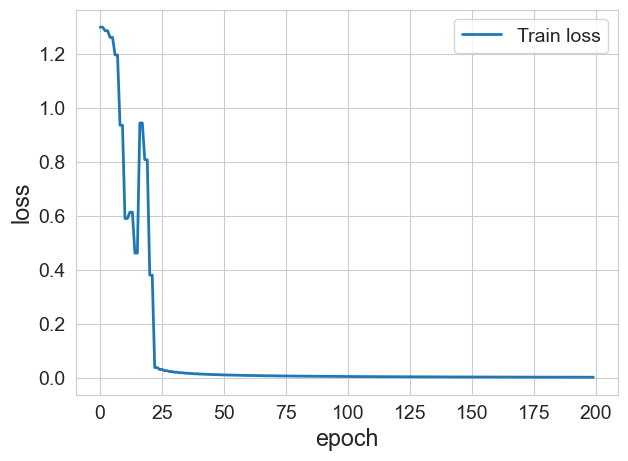

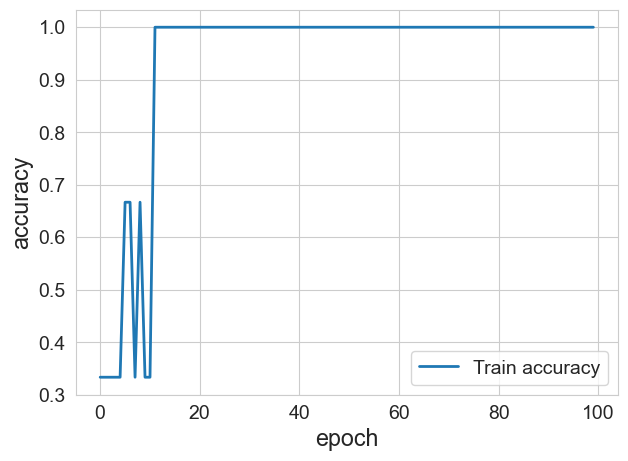

In [4]:
# mlp  1-3-1
# 输入样本与期望输出
X = np.array([[1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1],
              [0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0],
              [1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1]])    
y = np.array([[1,-1,-1],[-1,1,-1],[-1,-1,1]])
train_dataset = (X,y)
test_dataset = None
param = {}        # 网络参数
input_size =X.shape[1]    # 输入层节点数目
hidden_size = 3   # 隐层神经元数目
output_size = len(y)   # 输出层神经元数目(类别数目)
param['input_size'] = input_size
param['hidden_size'] = hidden_size
param['output_size'] = output_size

# 设置初始权值和阈值
param['w1'] = np.random.randn(input_size,hidden_size)   # 隐层权值        # 默认"标准正态分布初始化"  
param['t1'] = np.zeros((1,hidden_size))                 # 隐层阈值        # 默认 0
param['w2'] = np.random.randn(hidden_size,output_size)  # 输出层权值
param['t2'] = np.zeros((1,output_size))                 # 输出层阈值

# 设置算法参数
lr = 0.2                                    # 学习率
epochs = 100                               # 最大训练轮数
eps = 1e-4                                     # 训练停止精度要求
log_epochs = 5

print("====================================================================")
print("开始训练 ......")
# 训练模型
loss,score,param = mlp2_train(train_dataset,test_dataset,param,lr,epochs,eps,log_epochs=log_epochs)

#fig_path = os.path.normpath(f'image/classification/moon_mlp/fig/noise{noise}')
fig_path = os.path.normpath('image/classification/ex/3-8/fig')
fig_path = os.path.normpath(os.path.join(fig_path,f"h{hidden_size}_o{output_size}_lr{lr}"))
# (3) 可视化 --- 观察训练集与验证集的指标变化情况  
# (3.1) 绘制训练\测试 损失变化曲线
fig_name = 'train-test-{}.pdf' 
param_name = 'epoch'    
metric_name =  'loss' 
train_results = (loss['train'],[])
test_results = (loss['test'],[])
draw_scores(fig_path,fig_name.format(metric_name),train_scores=train_results,
                      test_scores=test_results,metric=metric_name,param_name=param_name)
# (3.2) 绘制训练\测试 分类正确率变化曲线
fig_name = 'train-test-{}.pdf' 
param_name = 'epoch'    
metric_name =  'accuracy' 
train_results = (score['train'],[])
test_results = (score['test'],[])
# 绘制数据图像

data_type = 'all'  #  'train'    # 'test'  
# moons.draw_data(fig_path, fig_name='3-8-data.pdf'.format(data_type,noise)) 

draw_scores(fig_path,fig_name.format(metric_name),train_scores=train_results,
                      test_scores=test_results,metric=metric_name,param_name=param_name)
